# Assignment 2

### Import

In [549]:
%matplotlib inline
import urllib2
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import collections
import numpy as np
from collections import Counter
from collections import defaultdict
from __future__ import division
import io
import sys
import operator
from math import log10, floor
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import timeit
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

# Part I: Community Structure

** Explain the concept of modularity in your own words. ** 

**Modularity** is a measurement that allows us to quantify the goodness of a partition of a network into communities, where partition is a division of a network into an arbitrary number of groups such that each node belongs to one and only one group. More specifically, Modularity is a concept that measures systematic deviations from a random configuration of a network. This helps us indentifying groups that are embedded in a network, and finding nodes that interact more frequantly with each other than in a random network. Therefore modularity is simply a measurement of the systematic deviations from a random configuration. Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules

The modularity of a network can be calculated with the following equation

Equation 9.12

$$ M_c = \sum_{c=1}^{n_c}[ \dfrac{L_c}{L} - (\dfrac{k_c}{2L}) ] $$

where:

    * L : total number of links in the network
    * Lc = number of links in each community 
    * kc = total degree of the nodes

Note that kc is the total degree of the nodes in the graph but Lc is the number of links withing the subgraph that the community creates. Therefore we do not count edges that goes between communities for Lc.  


** Now, calculate the modularity of the branches reported by the Wikipedia editors **

We start by creating a dictionary that contains the names of all philosophers in the each branch of philosophy

In [596]:
philosophers = {
    "aestheticians":{ "title":"title=List_of_aestheticians", "names":""},
    "epistemologists":{ "title":"title=List_of_epistemologists", "names":""},
    "ethicists":{ "title":"title=List_of_ethicists", "names":"" },
    "logicians":{ "title":"title=List_of_logicians", "names":"" },
    "metaphysicians":{ "title":"title=List_of_metaphysicians", "names":"" },
    "social and political philosophers":{ "title":"title=Index_of_sociopolitical_thinkers", "names":""}
}

We then loop through each branch's wikipage and collect the names of the philosophers

In [597]:
# set the parameters (explained in detail here https://www.mediawiki.org/wiki/API:Tutorial)
baseurl = "https://en.wikipedia.org/w/index.php?"
title = ""
action = "action=edit"

for i in philosophers:
    # construct the query
    query = "{}{}&{}".format(
        baseurl,
        philosophers[i]["title"],
        action
    )
    
    # use urllib and regex to get the list of philosophers
    wikiresponse = urllib2.urlopen(query)
    wikisource = wikiresponse.read()
    philosophers[i]["names"] = re.findall(r'\*.*?\[\[(.*?)[\]\|]', wikisource)

# Because the last 4 elements of the ethicists list and social and political philosophers are not philosophers
# they are left out
philosophers["ethicists"]["names"] = philosophers["ethicists"]["names"][:-4]
philosophers["social and political philosophers"]["names"] = philosophers["social and political philosophers"]["names"][:-4] 

Then we loop through each philosopher's wikipage and in each page we find the links to other philosophers. From that information we create the undirected graph

In [613]:
G = nx.Graph() # Create a undirected graph

# First of all get all the philosophers
all_philophers = []
for i in philosophers:
    all_philophers = all_philophers + philosophers[i]["names"]

all_philosophers_uniq = set(all_philophers)
    
counter = 0

# set the parameters for the query (explained in detail here https://www.mediawiki.org/wiki/API:Tutorial)
baseurl = "https://en.wikipedia.org/w/api.php?"
actions = "action=query"
title = "titles="
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# iterate through the philosophers and for each philosphers download his wikipedia page
# The list comprehension goes through the list of philosophers and replaces " " for "_"
for philo in all_philosophers_uniq:
    query = "{}{}&{}{}&{}&{}".format(
        baseurl,
        actions,
        title,
        philo.replace(" ","_"),
        content,
        dataformat
    )
    #print(philo)
    #print(query)
    
    wikiresponse = urllib2.urlopen(query)
    theArticle = wikiresponse.read()
    
    # Add the philosopher to the graph
    G.add_node(philo)

    # use regex and the set.intersection function to find all philosophers that are linked from the 
    # wikipage of each philosopher
    linkedPhilosophers = set(re.findall(r'.*?\[\[(.*?)[\]\|]', theArticle)).intersection(all_philosophers_uniq)

    # Go through all the linked philosophers and add directed edge for each one
    for linkedPhilosopher in linkedPhilosophers:
        G.add_edge(philo,linkedPhilosopher)

 ** Algorithm procedure: **
 
 - Our network has more than one component, So we need to get the giant connected component (GCC) of our network. We call it giant_G. 
 - Then we find the all of the philosophers in that network that are part of more than one branch (the overlapping_philo variable).
 - If the philosopher is not in more than one branch we add him to a list of tuple pairs (name,community), we call this list philo_community_list. Therefore at this time in the program this list contains all philosophers that are only associated with one branch
 - The next step in our algorithm is to find a community for the philosophers that are in more than one branch (overlapping philosophers). The way we did it is that for each overlapping philosopher, we found all neighbours of that philosopher that are only in one branch (non overlapping neighbours). We then simply assigned the philosopher to the branch that most of his non overlapping neighbours are in, in other words we assigned the philosopher to the branch/community that he has most connections to. If the philosopher is not connected to any non overlapping philosopher then we simply chose a community at random. **Note** We decided to only consider the non overlapping neighbor of the overlapping philosopher because it does not make sens to consider a neighbor that has not yet been assigned to a new community by the rules of our algorithm  
 - Now philo_community_list contains all of the philosophers in the G_giant graph and each philosopher has been assigned to a community
 - Then we simply changed the philo_community_list into a dictionary and calculated the modularity of the community division.



In [614]:
# Get the Giant connected component (GCC)
giant_G = max(nx.connected_component_subgraphs(G), key=len)

# Get all philosophers in the giant connected component
giant_all_philosophers = giant_G.nodes()

giant_philosophers_counted = []

# Find all philosophers that appear in more than one list
for branch in philosophers.keys():
    for philo in philosophers[branch]["names"]:
        if philo in giant_all_philosophers:
            giant_philosophers_counted.append(philo)
            
giant_philosohers_counted = Counter(giant_philosophers_counted)

# The next step is to find all of the philosophers that are part of more than one branch
overlapping_philo =[philo for philo,value in giant_philosohers_counted.items() if value > 1]

# create the communities dictionary for the philosophers
philosophers_communities = {
    "aestheticians" : [],
    "epistemologists" : [],
    "ethicists" : [],
    "logicians" : [],
    "metaphysicians" : [],
    "social and political philosophers" : []
}

# Now we create a list of tuple pairs (name,community) that contain all philosophers that only appear in one list
philo_community_list = []
for community in philosophers_communities.keys():
    for name in philosophers[community]["names"]:
        # Add the philosopher if he is not overlapping 
        if name in giant_all_philosophers:
            if name not in overlapping_philo:
                philo_community_list.append((name,community))
                

# Now we go through the list of overlapping philosophers and add them to the list with a assigned community
philo_community_list_overlapping = [] # temp list that contains the added overlapping philos
for philo in overlapping_philo:
    # next we find the non overlapping neighbours of each overlapping philo.  
    neighbors = [neighbor for neighbor in philo_community_list if neighbor[0] in giant_G.neighbors(philo)]
    community = ""
    if neighbors: # check if neighbours is not an empty list
        # find the most common community
        neighbors_communities = Counter(neighbor_tuple[1] for neighbor_tuple in neighbors)
        community = max(neighbors_communities.items())
        # Check if there are communities that are equals if so then choose randomly from them
        community = np.random.choice([k for k, v in neighbors_communities.items() if v == community[1]])
    else:
        # in case of no neighbour we choose the community by random
        community = np.random.choice(["aestheticians","epistemologists","ethicists","logicians","metaphysicians","social and political philosophers"])
    
    # Add the phylosopher to the philo_community_list
    philo_community_list_overlapping.append((philo,community))

# Add the newly assingd overlapping philosophers to the philo_community_list
philo_community_list = philo_community_list + philo_community_list_overlapping

# We end by adding the philosophers into their communities in a dictionary
for philo in philo_community_list:
    philosophers_communities[philo[1]].append(philo[0])

Now every philosopher in the giant component of our graph has been assigned to a branch. Therefore the division of the philosophers into a communities is done and we can calculate the modularity.

In [615]:
# Then we loop throught the communities and calculate the modularity (Mc) for each community
modularity = []
L = len(giant_G.edges()) # L : total number of links in the network
for community in philosophers_communities.keys():
    sub_graph = giant_G.subgraph(philosophers_communities[community]) # Create a subgraph for the community
    Lc = len(sub_graph.edges()) # Total number of edges in the community
    kc = sum([giant_G.degree(philo)  # Get the total degrees of the nodes in the community
              for philo in philosophers_communities[community]]) 
    M = (Lc/L)-((kc/(2*L))**2) # calculate the modularity for the community with equation 9.12
    modularity.append(M)

"The modularity is:    {}".format(sum(modularity))

'The modularity is:    0.158835003578'

** Comment on your value of $M$ for the branches. Are the branches good communities? **

We got the value of modularity as ~0.1588, but bare in mind there is a random factor in our algorithm so the result might vary a littlebit in each iteration but not much. As stated in Network Science in Chapter 9 there are several key properties to modularity. You can have a negative value of modularity which occurres if we assign each node to a different community. Modularity of zero means that we take the whole network as a single community. Modularity can not go above 1 but the higher it is for a specific partition of the network, the better is the corresponding community structure. There are examples of optimal and suboptimal partitions in the book for a specific network. There the optimal modularity is 0.41 but the sup optimal modularity has the value 0.22. This gives us an idea of how good our partitioning is but to fully understand it we need to find the modularity of the optimal partitioning of the G_giant graph

**Now, let us use the Python Louvain-algorithm implementation to find communities in the full philosopher network **


In [616]:
import community
import networkx as nx
import matplotlib.pyplot as plt


# First compute the best partition
partition_giant = community.best_partition(giant_G)
partition_full = community.best_partition(G)

# Find how many communities there are in the partition 
communities_giant = Counter([value for key,value in partition_giant.items()])
communities_full = Counter([value for key,value in partition_full.items()])

print "The full philosophy network is split up to {} communities".format(len(communities_full))
print "The modularity of this community division is {}".format(
    community.modularity(partition_full,G)
)

print "" 

print "The giant component of the philosophy network is split up to {} communities".format(len(communities))
print "The modularity of this community division is {}".format(
    community.modularity(partition_giant,giant_G)
)


The full philosophy network is split up to 210 communities
The modularity of this community division is 0.454005049928

The giant component of the philosophy network is split up to 12 communities
The modularity of this community division is 0.455676160125


__Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches?
__

The **full network** is not a complete graph. The giant component of that graph contains 838 nodes but the full network contains 1047 nodes. To understand the behavior better we plotted up both the full network and the giant component. We colored the nodes based on the community that they are assigned to. What the plot reveals is thet there are many philosophers that are not connected to any other philosophers. What the algorithm most likely does for the full network is that it creates many communities which contains very few nodes(philosophers) in the graph and then it devides the giant component up to three communities. We did not consider it to be relevant to focus more on the full network because in our algorithm we are only dividing the giant component up to communities and calculating the modularity based on that division. **Therefore we will only focus on the giant component in the following analysis**

The optimal partition of our giant component partitiones the network into 12 communities. This division results in a modularity of 0.45401. Our algorithm is dividing the community into 6 communities, one for each brand. That division resulted in a modularity of ~0.1588 which is quite far away from the optimal modularity value for the graph but it is much higher than zero. Therefore we can safely concluded that the partitioning is sub optimal but not nearly optimal. We are dividing the giant component into fewer communities but still resulting in a division which is much higher than zero. 

**Conclusion:** This reveals that the branches division is quite good community division but not nearly optimal.

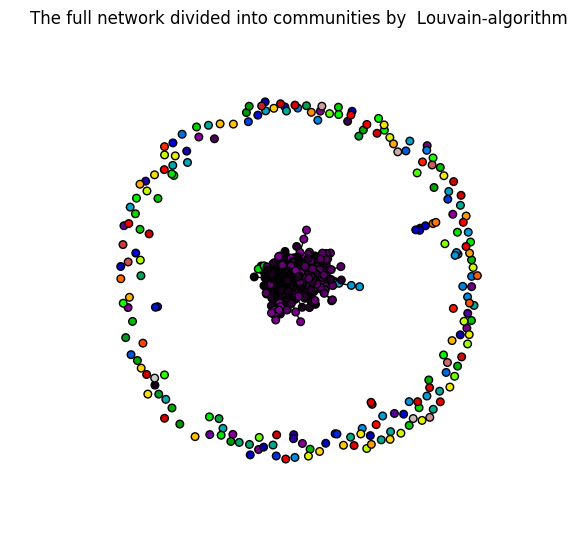

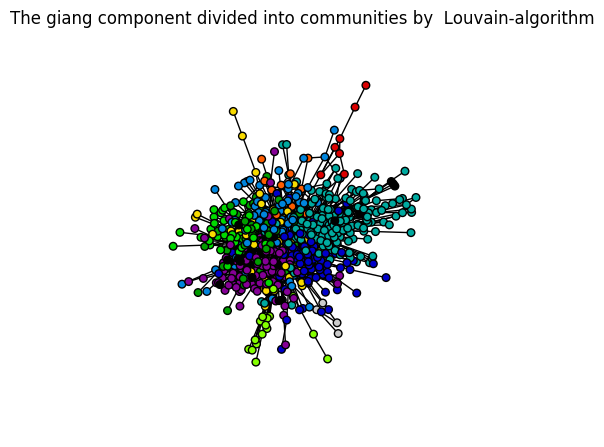

In [617]:
# to get an idea about the partition we plot it with colours representing each community:
# the full network divided by the Louvain-algorithm
plt.figure(figsize=(5,5))
values = [partition_full.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap = plt.get_cmap('nipy_spectral'), node_color = values, node_size=30, with_labels=False)
plt.title('The full network divided into communities by  Louvain-algorithm')
plt.show()

# The giant component divided by the Louvain-algorithm
plt.figure(figsize=(5,5))
values = [partition_giant.get(node) for node in giant_G.nodes()]
plt.title('The giang component divided into communities by  Louvain-algorithm')
nx.draw_spring(giant_G, cmap = plt.get_cmap('nipy_spectral'), node_color = values, node_size=30, with_labels=False)
plt.show()


** Compare the communities found by your algorithm with the branches (that you analyzed abo ve) by creating a matrix D with dimension ($B$ times $C$), where $B$ is the number of branches and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that branch $i$ has in common with community $j$. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy. ** 

**Note** In the following analysis we are only working with the philosophers that are part of the giant component of the philosopher network

In the following section we will by comparing the communities found by the Louvain-algorithm with the branches partition that we created which contains no overlapping philosophers.

In [558]:
import numpy as np

# We start by creating a 6*12 matrix

# Remember that partition_giant contains the optimal division of the algorithm
# and philosophers_communities contains our community algorithm division of the philosophers.

B = 6 # number of branches
C = 12 # number of communities in the optimal solution

confusion_matrix = np.empty((B,C,))
confusion_matrix[:] = 0

#Let's loop through our branches
for i,branch in enumerate(philosophers_communities.keys()):
    #Loop through our philosophers from the community.best_partition algorithm
    for philosopher in partition_giant:
        #We then check if said philosopher is in said branch
        if philosopher in philosophers_communities[branch]:
            #If that is the case we increment the value of the matrix at [branch,community number] position
            confusion_matrix[i,partition_giant[philosopher]] += 1 

print("The confusion matrix")
print confusion_matrix

print("")

for i in philosophers_communities:
    print 'Size of the ' + i + ' branch: ' + str(len(philosophers_communities[i]))

The confusion matrix
[[  13.  111.   28.   24.   10.   26.   41.   12.   22.    0.    0.    2.]
 [  12.   20.    7.   15.    4.    6.    1.    0.   13.    0.    0.    0.]
 [   8.    2.   37.    2.  136.    5.    0.    1.    6.   10.    7.    0.]
 [   2.    5.    6.   17.    7.    2.    5.    0.    1.    0.    0.    2.]
 [   2.    8.   18.    8.   15.    2.    1.    0.    3.    0.    0.    0.]
 [   8.   20.   31.   42.    4.   27.    5.    6.    9.    1.    0.    0.]]

Size of the social and political philosophers branch: 289
Size of the aestheticians branch: 78
Size of the logicians branch: 214
Size of the epistemologists branch: 47
Size of the metaphysicians branch: 57
Size of the ethicists branch: 153


Let's look at the confusion matrix for one branch at a time:
<break/>
**Note:** Go straight to the conclusion if you are not overly exited about this matter

* __Social and political philosopers:__ We can see that almost 40% of them are in community number 2 while the rest is split rather evenly between communities 1,3,4,5,6,7,8,9 while in community 10-12 there are only 2 nodes. Those two outliers are Hans Achterhuis and Langdon Winner, both of which are quite 'young' in term of our philosophers age. The two of them have worked together but their pages don't reference many other philosophers which explains their small community. The two other nodes in community 12 are Donna Haraway and Sandra Harding. Donna has also worked with Hans while Donna has criticized work by Sandra. Both Sandra and Donna are around the same age as Hans and Langdon.

*  __Aestheticians:__ It's seems they are relatively evenly split between communities 1-4,6,9 where 95% of the nodes are. In community number 7 there is only one node, Clive Bell, his only connection is his father-in-law Leslie Stephen who is in the branch of ethicists and community 7. There are 3 nodes from the branch in community 5, one of which was initially in more than one branch, one of which was Logicians which makes sense as in community 5 80% of the nodes are from the branch of Logicians.

* __Logicians:__ Here we have around 64% of the nodes from the branch in the same company which indicates that our partioning for this branch was quite good. We have two nodes that are by themselves in a community. The first one is in community 2 and is Alexander Zinoviev, who has only one neighbour, Karl Marx. Karl Marx is from the Social and political philosophers branch and so are 65% of the nodes in community 2 which explains why Zinviev is there. The other loner is in community 8 and is Hui Shi which has two neighbours Xun Kuang from the branch of Ethicists and Zhuang Zhou from the branch of Social and political philosophers. We can see from community 8 that Hui Shi is a good fit there as all nodes but his are from the branches of his two neighbours.

* __Epistemologists:__ We can see that most of the nodes are split into communities 1-7 and 2 nodes in community 12 which we analyzed in the part about Social and political philosophers. Then we have 1 node in community 9. Isaac Levi is the loner in this branch. He has 3 neighbours Charles Sanders Peirce from the Logicians branch, John Dewey from the Aestheticians branch and William James from the branch of Social and political philosophers. The majority of nodes in community 9 is from those three branches.

* __Metaphysicians:__ Here we have a outlier in community 6, William Alston who originally was also in the branch of Epistemologists. He also has 9 neighbours, 4 of which are from the branch of Social and political philosophers, around 37% of the nodes in community 6 are from that branch as well. The majority of the branch is divided into communities 2-5.

* __Ethicists:__ We can see that most of the nodes are distributed between communities 2-4 and 6 mainly with the rest in communities 1,5,7-9. Then we have a lonely node in community 10. The lonely philosopher is Philip Pettit, he belonged originally to two branches, Ethicists and the branch of Social and political philosophers. He has 4 neighbours, each from a different branch Ethicists, Social and political philosophers, Metaphysicians and Logicians. However three of his neighbours were also 'overlapping philosophers', that is belonged to more than one branch originally, and therefor Philip was assigned to the same branch as the fourth neighbour, Amartya Sen. Community 10 is dominated by Logicians and Philip's connection there is his neighbour Lorenzo Peña who is a Logician and is in community 10.

<break/>
**Conclusion:** Overall our branches are quite distributed amongst communities 1-9 (~98% of the nodes) which tells us that perhaps wikipedia should use more branches to classify their philosophers. We can also see that the branch of Logicians is by far the best partioning from our algorithm with ~64% of their nodes in the same community while all other branches have at most 26-38% of their nodes in the same community. The two worst branches from our partition are the branches of Aestheticians and Ethicists with at most ~26.9% of their nodes in one community.

**Extra** To further investigate how our algorithm is behaving we carried out the following analysis. Here we will compare the communities found by the algorithm that we created with the "true" branches of philosophers in wikipedia. 

In [621]:
import numpy as np

# We start by creating a 6*6 matrix

# Remember that philosophers dictionary contains the division from wiki
# and philosophers_communities contains our community algorithm division of the philosophers.

B = 6 # number of branches
C = 6 # number of communities

confusion_matrix2 = np.empty((B,C,))
confusion_matrix2[:] = np.NAN

for i,branch in enumerate(philosophers.keys()):
    for j,community in enumerate(philosophers_communities):
        confusion_matrix2[i,j] = len([philo for philo in philosophers_communities[community] 
                                 if philo in philosophers[branch]["names"]])
        
print("The confusion matrix")
print confusion_matrix2

print("")

print("The size of each branch of philosophers only counting the philosophers that are part of the giant component:")
print("-----------------------------------------------------------")
for i,philosopher in enumerate(philosophers):
    print 'Size of the ' + philosopher + ' branch: ' + str(confusion_matrix2[i].sum())   

# number of True positives
true_positives = 0
for i,row in enumerate(confusion_matrix2):
    true_positives += row[i]

The confusion matrix
[[ 267.    1.    2.    2.    5.    5.]
 [  20.   70.    1.    0.    0.    3.]
 [  10.    2.  206.    0.    4.    3.]
 [  27.    1.    5.   46.    3.    4.]
 [  16.    1.    8.    1.   56.    7.]
 [  50.    0.    3.    2.    5.  150.]]

The size of each branch of philosophers only counting the philosophers that are part of the giant component:
-----------------------------------------------------------
Size of the social and political philosophers branch: 282.0
Size of the aestheticians branch: 94.0
Size of the logicians branch: 225.0
Size of the epistemologists branch: 86.0
Size of the metaphysicians branch: 89.0
Size of the ethicists branch: 210.0


Just by looking at the confusion matrix it can be seen that our algorithm is putting way to many philosophers into the branch social and political philosophers. This is understandable when you consider how the algorithm assigns the philosophers that are part of more than one branch into community. The algorithm finds all non overlapping friends of each overlapping philosophers and assings the overlapping philosopher to the community that most of his friends are part of. The Social and Political branch is by far the biggest and therefore in most cases the algorithm will assign the overlapping philosopher to that branch. This does not seem to be a good way to assign the non overlapping philosophers to communities.  


# Part II: Human navigation paths

## IIa: Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths.

### Exercise

** For each source/target pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths**


We decided to use undirected graph. We start of by creating a undirected graph from the links.tsv file. We simply run through the file line by line. For each line (except the first 12 lines which only contain information about the dataset) we add an edge to the graph.

In [353]:
# Read in the links.tsv file
file_path = 'links.tsv'

G = nx.Graph()

with io.open(file_path, encoding="utf-8") as f:
    lines = f.readlines()
    lines = lines[12:]
    for line in lines:
            line = line.split()
            G.add_edge(line[0],line[1])            
print("number of nodes: {}".format(len(G.nodes())))
print("number of edges: {}".format(len(G.edges())))

number of nodes: 4592
number of edges: 106647


The next step is to go through the finished paths and get each source target pair

In [367]:
# container that contain the tuple pairs (source, target, length of path)
human_navigation_paths = []

# Read in the links.tsv file
file_path = 'paths_finished.tsv'

G_humanpaths = nx.Graph()
paths = [] # container for all the completed human paths

with io.open(file_path, encoding="utf-8") as f:
    lines = f.readlines()
    lines = lines[16:] # Take out the lines that are not links
    for line in lines:
        line = line.split()[3] # Get the path from the line
        line = line.replace(";<","") # Back clicks are represented as "<", here we delete them from the path
        line = line.split(";") # split the path on ; to get an array of websites
        G_humanpaths.add_path(line) # add the path to the human path graph
        paths.append(line)
        source = line[0] # find the source website
        target = line[-1] # find the target website
        
        # note that we take the length of the path as the number of nodes in the path - 1 
        # we subtract one as the edges are one less than the nodes
        human_navigation_paths.append((source,target,len(line)-1)) # add the tuple (source, target, length of path)  

Now everything is ready to calculate the shortest path between each source target pair. The reason for the try and catch block is that the node "Wikipedia_Text_of_the_GNU_Free_Documentation_License" is not part of the links list and therefore it is not in our graph. This is most likely just a minor error in the dataset

In [368]:
# Container for the shortest path for each source/target pair. Contains the tuple (source, target, shortest path length)
shortest_paths = []    

for source,target,_ in human_navigation_paths:
    try:
        shortest_paths.append( 
            (
                source,
                target,
                nx.shortest_path_length(G,source=source,target=target)
            )
        )
    except:
        print ("Unexpected error:", sys.exc_info()[0])
        print("target : {}".format(target))
        print("source : {}".format(source))
            

('Unexpected error:', <class 'networkx.exception.NetworkXError'>)
target : Wikipedia_Text_of_the_GNU_Free_Documentation_License
source : Bird


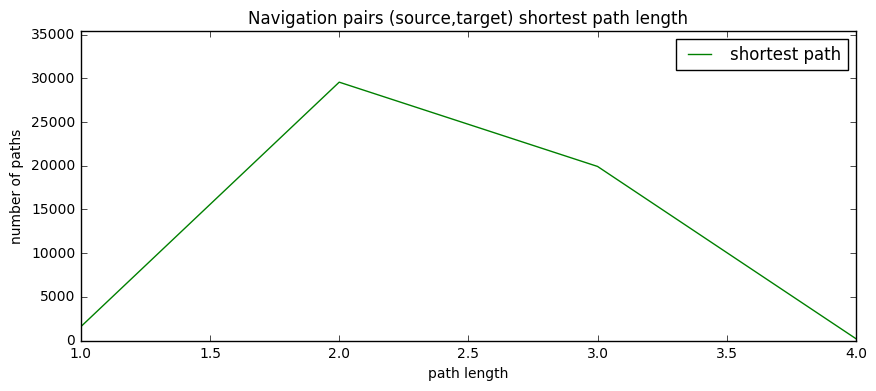

In [378]:
# Get the length of the shortest paths
shortest_path_lengths = [length for source, target, length in shortest_paths]

# plot the distribution
plt.figure(figsize=(10,4))
plt.plot(list(Counter(shortest_path_lengths).keys()), list(Counter(shortest_path_lengths).values()), color="green")
plt.xlim((1, 4))
plt.ylim(0,max(list(Counter(shortest_path_lengths).values()))*1.2)
plt.title("Navigation pairs (source,target) shortest path length")
plt.xlabel("path length")
plt.ylabel("number of paths")
plt.legend(["shortest path"])
plt.show()

 - From this graph it can be seen that most of the target websited can be reached in only 3 clicks or fewer, from a given source. 
 - For each (source,target) pair in the game it is possible to complete the game in only 4 clicks
 
 This will gives us the foundation to evaluate the lenght of the human paths. We now know that for each target/source assignment the human should be able to finish the assignment in no more than 4 clicks. But we also know that he needs to be both lucky and quite bright to do so :). 
 
 This corresponds well to the small world phenomenon, which states that if you choose any two individuals anywhere on Earth, you will find a path of at most six acquaintances between them. This is do to the fact that the network contains hubs that have high centrality betweenness (large wikipages that have many links) and can therefore act as a gateway connecting the source and the target websites.

** For each source/target pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths**
 
*We decided to just **remove** the back icon (<) from the human navigation paths*

**Justification**:

- We decided to only count the clicks on the wikipedia links, therefore we simply removed the back icon from each path. One of the reasons why we did that is that the graph we use is undirected and a link 'back' is the same as a link 'forward' and therefore we don't count the 'backs'.

- Another reason is that the breadth first search algorithm uses backs when finding the shortest path in a graph but does not count it.  Therefore, we think it is only fair that the human's can enjoy the same benefits. For more information on breadth first search click this [link](http://barabasi.com/networksciencebook/) and navigate to the chapter two of the book.



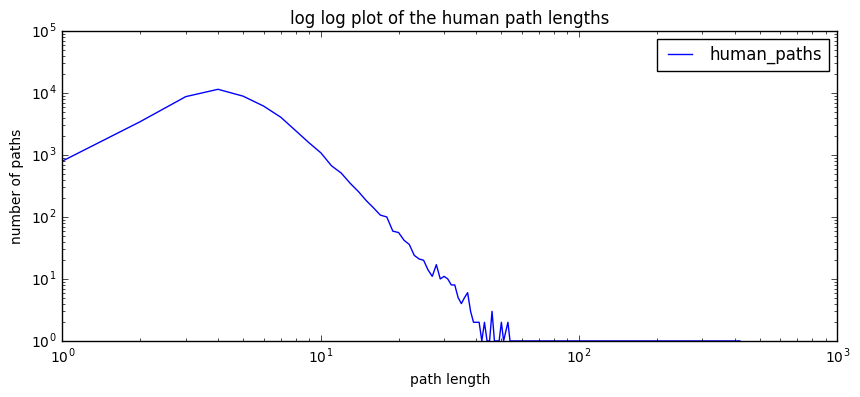

The mean value of the human path length is:     5.357
The median value of the human path length is:   5.0
Percentage of paths of length 6 or less is:     0.7686


In [399]:
keys, values = zip(*sorted(Counter([length for target,source,length in human_navigation_paths]).items(), 
                              key = operator.itemgetter(0)))

plt.figure(figsize=(10,4))
plt.plot(keys, values)
plt.xscale("log")
plt.yscale("log")
plt.title("log log plot of the human path lengths")
plt.xlabel("path length")
plt.ylabel("number of paths")
plt.legend(["human_paths"])
plt.show()


# Find the mean and the median values for the human navigation lengths
print ("The mean value of the human path length is:     {}").format(
    round_sig(np.mean([length for target,source,length in human_navigation_paths]),4)
)
print ("The median value of the human path length is:   {}").format(
    np.median([length for target,source,length in human_navigation_paths])
)


# We decided to do some extra work and find the % of the paths that er higher than 6
all_nums = [x[2] for x in human_navigation_paths]

num_under_6 = len([x for x in all_nums if x <= 6])
num_over_6 = len([x for x in all_nums if x > 6])

print "Percentage of paths of length 6 or less is:     " + str(round_sig(
    num_under_6/(len(human_navigation_paths)),
    4
))




Looking at the distribution it can be seen that most of the human navigation paths lengths fall around the value 4, which is surprisingly good. The distribution is skewed and there are some clear outliers in the distribution. It is interesting to see that the maximum human navigation path length is 419. Another interesting thing to notice is that 76.9% of the path lengths are smaller or equal to 6, which is in compliance with the small world phenomenon.

** How much longer are the human paths on average? **

In [392]:
human_path_avg = np.mean([length for target,source,length in human_navigation_paths])
shortest_path_avg = np.mean([length for source, target, length in shortest_paths])

print("The human paths average is           {}".format(round_sig(human_path_avg,4) ))
print("The shorest paths average is         {}".format(round_sig(shortest_path_avg,4) ))
print("-------------------------------------------")
print("The difference is                    {}".format(round_sig(human_path_avg - shortest_path_avg,4)))

The human paths average is           5.357
The shorest paths average is         2.365
-------------------------------------------
The difference is                    2.992


Here it has to be taken into the account that there are some clear outliers in the human navigation path lengths which influance the mean value. The median value of the human navigation path lengths is 5 which is more representative of distribution.

** Create scatter plot where each point is a source/target pair, and you have human path lengths on the x-axis and shortests paths on the y-axis. **

We start of by creating two dictionaries. One that contains the shortest path length of every source/target pair. And another that contains every human path length for each source/target pair

In [372]:
shortest_path_dict = defaultdict(set)
human_navigation_path_dict = defaultdict(list)

# get values into the shortest path dictionary
for source, target, length in shortest_paths:
    shortest_path_dict[(source, target)].add(length)

# get values into the human path dictionary
for source, target, length in human_navigation_paths:
    human_navigation_path_dict[(source, target)].append(length)
    
# create a list of tuples of the form (shortest path, human path)
shortest_vs_human = []
for source, target in shortest_path_dict.keys():
    for human_length in human_navigation_path_dict[(source, target)]:
        shortest_vs_human.append(( list(shortest_path_dict[(source,target)])[0], human_length))

Now we have all of the information we need to plot each human path lenght source/target pair point against the shortest path value for that specific source/target pair

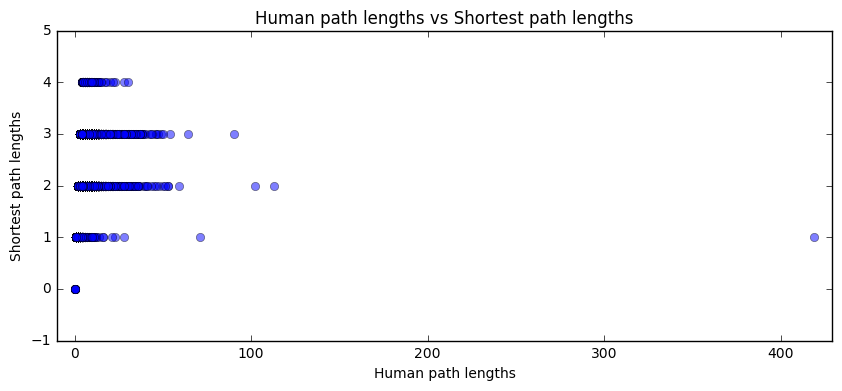

In [400]:
# Create the plot

# We start by reverse ziping the shortest_vs_human tuples array
y,x = zip(*shortest_vs_human)

# The we plot the result
plt.figure(figsize=(10,4))
plt.plot(x, y, "o", alpha=0.5)
plt.xlim(-10, max(x)+10)
plt.ylim(-1, max(y)+1)
plt.title("Human path lengths vs Shortest path lengths")
plt.xlabel("Human path lengths")
plt.ylabel("Shortest path lengths")
plt.show()

Here the outlier can be seen quite well. This individual should have been able to finish the taks in one click but he manage to use 419 clicks, which is quite impressive. Another interesting thing to notice is that the outliers are not correlated with the shortest paths. You would think that most of the longer human paths would be where the shortest path has a value of 4, which is not the case. 

** Is there a correlation between human/shortest path-lengths? What is the correlation. **

You can clearly see on the figure here above that there is no correlation between human/shortest path-lengths. This can investigated further by using the numpy module to calculate the correlation between x and y. The code to accomplish this can be seen here below. The result was that the correlation between x and y is 0.20678837 which supporst the hypothesis that the human/shortest path-lengths are not correlated.

In [377]:
np.corrcoef(x,y)

array([[ 1.        ,  0.20678837],
       [ 0.20678837,  1.        ]])

## IIb: Betweenness

** Navigation centrality :** Navigation centrality of node i is the fraction of all naviagtion paths that pass through i. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

### Exercise

** Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset. Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.**

** First, list the 5 pages with highest navigation centrality.**

Calculate the navigation centrality for each node/website

In [404]:
navigation = defaultdict(float) # contains the navigation score for each website
nr_of_paths = len(paths) 

# For each website we go through every path in the paths_finished file
# and we count how many times the website is in a path (not source nor target)
for website in G.nodes():
    freq = 0
    for path in paths:
        path = path[1:-1] # Deleting the source and the target from the path 
        if website in path:
            freq += 1
    navigation[website] = freq/nr_of_paths

Print out the top five websites

In [409]:
navigation_sorted = sorted(navigation.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)
print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = "Website:", centrality_d = "Navigation centrality value:"
        ))

print("-------------------------------------------------------")

for page, centrality in navigation_sorted[:5]:
    print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = page, centrality_d = round_sig(centrality,5)
        ))

Website:                   Navigation centrality value:
-------------------------------------------------------
United_States              0.16766       
Europe                     0.083012      
United_Kingdom             0.073327      
Earth                      0.060525      
England                    0.059472      


** Second, list the 5 pages with highest betweenness centrality. **

In [411]:
betweenness = nx.betweenness_centrality(G) # calculate the betweenness of the network

print out the top five websites

In [413]:
betweenness_sorted = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)

print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = "Website:", centrality_d = "Betweenness centrality value:"
        ))

print("-------------------------------------------------------")

for page, centrality in betweenness_sorted[:5]:
    print ("{webpage_s: <26} {centrality_d: <14}".format(
            webpage_s = page, centrality_d = round_sig(centrality,5)
        ))

Website:                   Betweenness centrality value:
-------------------------------------------------------
United_States              0.12522       
United_Kingdom             0.047387      
Europe                     0.044658      
France                     0.036809      
England                    0.033597      


** Compare the two lists. Explain the differences between the two lists in your own words. **

- Both lists have only locations as the highest values; countries, continents, and planets. 
- In both cases, the United States has by far the highest score. 
- The only pages that don't appear in both lists are France and Earth. 
- France contains more of the actual shortest paths while the human users click more on the link that contains the Earth-wikipedia page.

The lists are very similar because the player tries to find a hub in the network. In other words the player tries to find a wikipage that has links to many other websites as well as a broad spectrum of information. However these hubs may not neccesarily fall on the shortest path, thus they might have a lower betweenness.

In [418]:
# We will compare the two lists by finding how many item are the same in both lists
# the function prints out how many items are common in each list,
# it also prints out the common websites and the websites that are different in for each centrality

def compareCentralities(navigation_C, betweenness_C, n, p):
    navigation_subset = [website for website,_ in navigation_C[:n]]
    betweenness_subset = [website for website,_ in betweenness_C[:n]]
    
    intersection = [website for website in navigation_subset if website in betweenness_subset]
    
    if p == True:
        print ("The intersection between the two centralities for the top {} items are:".format(n))
        print ("---------------------------------------------------------------------")
        for i in intersection:
            print(i)
        
        print ("\nThe distinctive items in the navigation centrality for the top {} items are".format(n))
        print ("----------------------------------------------------------------------")
        for i in [website for website in navigation_subset if website not in intersection]:
            print(i)
            
        print ("\nThe distinctive items in the betweenness centrality for the top {} items are".format(n))
        print ("----------------------------------------------------------------------")
        for i in [website for website in betweenness_subset if website not in intersection]:
            print(i)
        
    # returns the fraction of intersection items between the two centralities
    #return len(intersection)/n

# let´s visualize the difference between these two centralities
compareCentralities(navigation_sorted, betweenness_sorted, 5, True)

The intersection between the two centralities for the top 5 items are:
---------------------------------------------------------------------
United_States
Europe
United_Kingdom
England

The distinctive items in the navigation centrality for the top 5 items are
----------------------------------------------------------------------
Earth

The distinctive items in the betweenness centrality for the top 5 items are
----------------------------------------------------------------------
France


** Create a scatterplot of betweenness centrality vs. navigation centrality.**

Here remember that A vs. B means that A = y axis, B = x axis

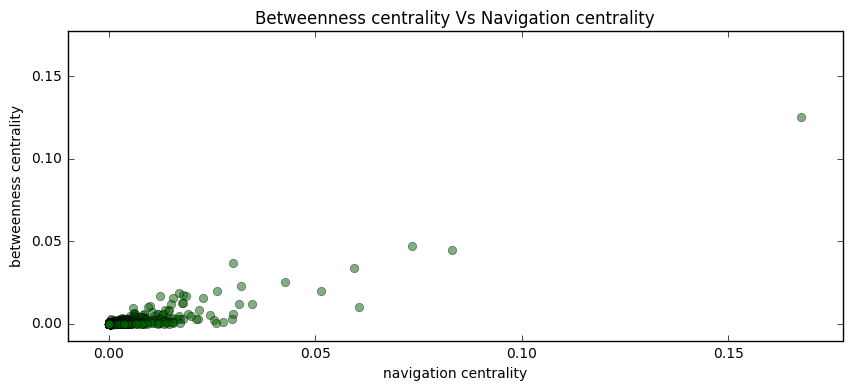

In [461]:
x = range(0,len(betweenness_sorted))
betweenness_values = [value for website,value in betweenness_sorted]
navigation_values = [navigation[website] for website,_ in betweenness_sorted]

plt.figure(figsize=(10,4))
plt.plot(navigation_values, betweenness_values, "o", color="darkgreen", alpha=0.5)
plt.title("Betweenness centrality Vs Navigation centrality")
plt.xlabel("navigation centrality")
plt.ylabel("betweenness centrality")
plt.xlim(-0.01,max(navigation_values + betweenness_values)+0.01)
plt.ylim(-0.01,max(navigation_values + betweenness_values)+0.01)
plt.show()

Here it can be seen that there is a high corrilation (0.8886) between the betweenness centrality and the navigation centrality. Outliers in the Navigation centrality are also outliers in the betweenness centrality

In [423]:
np.corrcoef(betweenness_values,navigation_values)

array([[ 1.       ,  0.8886482],
       [ 0.8886482,  1.       ]])

**Let's explore the pages that have navigation centrality equal to zero.**

- How many pages have zero navigation centrality?
- What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).
- Plot the distribution of betweenness centrality for the pages with zero navigation centrality.

** How many pages have zero navigation centrality **

In [430]:
# Find all pages with zero navigation centrality
zero_navigation_centrality = [website for website,value in navigation_sorted if value == 0]

print("There are {} pages that have zero navigation centrality".format(len(zero_navigation_centrality)))
print(" -> that is {} percent of all websites ({} in total) in the dataset".format(
        round_sig((len(zero_navigation_centrality)/len(navigation_sorted))*100,3), len(navigation_sorted)
    ))

There are 1187 pages that have zero navigation centrality
 -> that is 25.8 percent of all websites (4592 in total) in the dataset


** What is the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node). **

The page is *[List of lakes](https://en.wikipedia.org/wiki/List_of_lakes)* which has the betweenness centrality value of 0.0009143. The degree of the page's corresponding node in the graphs is 109, which is interesting when you considere that the average degree in the graphs is 46.449. Initially this came as an surprise but after further investigation it all started to make sens. The *[List of lakes](https://en.wikipedia.org/wiki/List_of_lakes)* contains a list of lakes by country and therefore can be considered as a some sort of an gateway to wiki pages of the countries. In our earlier work we found out that countries have really high centrality value for both betweenness centrality and navigation centrality. A wikipage of a country is, in most cases, huge page which contain vast amount of information and links in it. Therefore each country's wikipedia page can be cosidered as a gateway (hub) to many different things conserning that country and it is therefore a great decision in the game to click on those pages. A lot of people that finished the game figured this out which can be seen by inspecting the navigation centrality values. However no one figured out that the list of lakes page was a good way to access the countries wikipedia pages which is understandable, at least initially I did not consider it to be a good strategy to click on this page. 

In [433]:
# Find the betweenness centrality value for the pages that have 0 navigation centrality
navigationZero_betweenness = [(website, betweenness[website]) for website in zero_navigation_centrality]

website, betweenness_value = max(navigationZero_betweenness,key=operator.itemgetter(1))

# Find the page with the highest betweenness centrality
print ("The page with zero navigation centrality and highest betweenness centrality is: \n  '{}'".format(
    website
))
print ("  -> with betweenness centrality value of: {}".format(
    round_sig(betweenness_value,4)
))

print ("\nThe degree of the node '{}' in the graph is: {}. \nThe average degree in the graph is {}".format(
        website,
        G.degree(website),
        round_sig(np.mean(list(G.degree().values())),6)
    ))

The page with zero navigation centrality and highest betweenness centrality is: 
  'List_of_lakes'
  -> with betweenness centrality value of: 0.0009143

The degree of the node 'List_of_lakes' in the graph is: 109. 
The average degree in the graph is 46.449


** Plot the distribution of betweenness centrality for the pages with zero navigation centrality.** 

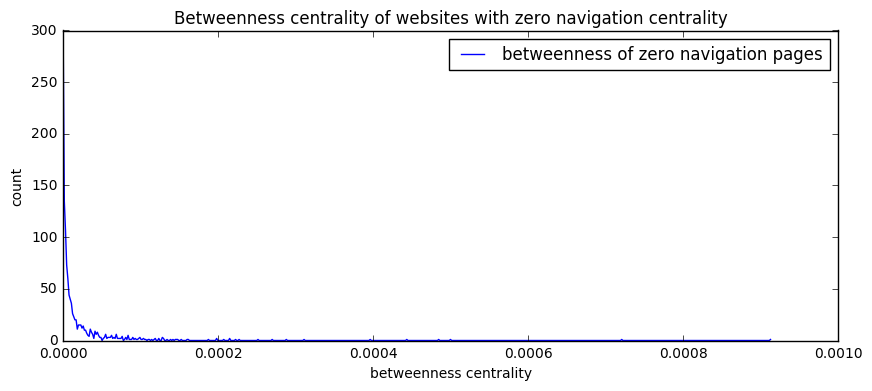

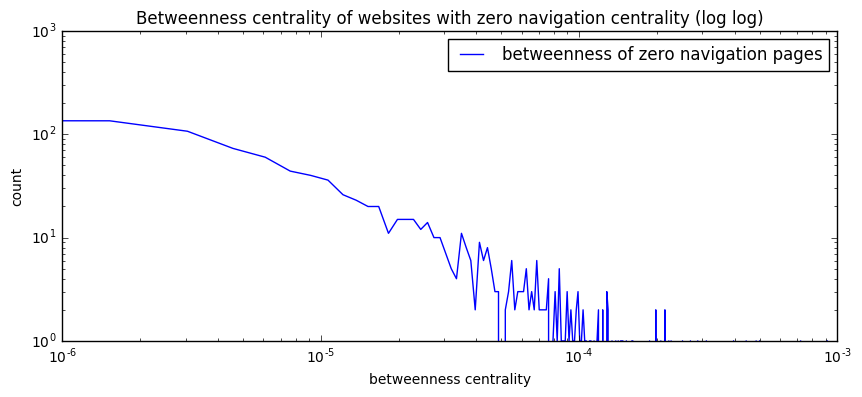

In [440]:
navigationZero_betweenness_values = [value for webpage,value in navigationZero_betweenness]

bins = 600
x,y = np.histogram(navigationZero_betweenness_values, bins)

plt.figure(figsize=(10,4))
plt.plot(y[:-1],x)
plt.title("Betweenness centrality of websites with zero navigation centrality")
plt.xlabel("betweenness centrality")
plt.ylabel("count")
plt.legend(["betweenness of zero navigation pages"])
plt.show()


plt.figure(figsize=(10,4))
plt.plot(y[:-1],x)
plt.xscale("log")
plt.yscale("log")
plt.title("Betweenness centrality of websites with zero navigation centrality (log log)")
plt.xlabel("betweenness centrality")
plt.ylabel("count")
plt.legend(["betweenness of zero navigation pages"])
plt.show()

- It can be seen on the figures that the distribution seems to follow the power law distribution. This is a representation of so called "80-20" for Paretor distribution where a vast majority of the betweenness centrality values falls within a small interval of values. 
- This reveals that most of the pages that people do not click on have low betweenness centrality. Most of the pages are in few shortest path between some source/target pairs.
- This again shows us how smart most people are in finding pages that can be considered as hubs in the network.

** Now, let's throw out all pages with zero navigation centrality and compare navigation and betweenness centrality for the remaining pages.**

    - What is the correlation between betweenness centrality and navigation centrality?
    - Comment on the top 5 outliers.


In [444]:
# Start by throwing out all pages with zero navigation centrality
navigationZero_betweenness_names = [webpage for webpage,value in navigationZero_betweenness]

# Now we want to get the data on the form (navigation value,betweenness value) 
# for each webpage that is not in navigationZero_betweenness_names
centrality_values = []

# We loop through the keys 
for website,_ in betweenness_sorted:
    if website not in navigationZero_betweenness_names:
        centrality_values.append(
            (
                navigation[website],
                betweenness[website]
            )
        )

Now we have the data on a format which allows us to evaluate the correlation quite easily. To evaluate the correlation we simply calculate the correlation with the numpy module.

In [478]:
navigation_reduced_values, betweenness_reduced_values = zip(*centrality_values)
np.corrcoef(navigation_reduced_values, betweenness_reduced_values)

array([[ 1.        ,  0.88920305],
       [ 0.88920305,  1.        ]])

** Correlation conclusion **

- The correlation between betweenness centrality and navigation centrality is 0.889203 and therefore we can conclude that the two centrality methods are highly correlated. This value is slightly higher than what we found previously when we did not delete the websites with zero navigation centrality, the value then was 0.8886482. 

** Comment on the top 5 outliers. **

To find the top 5 outliers we go through all of webpages in the dataset. For each webpage we calculate the euclidean distance from the mean in the navigation/betweenness scatter plot

$d =  \sqrt{ (\mu_{navigation} - x_{navigation})^2 + (\mu_{betweenness} - x_{betweenness})^2 } $

After calculating the distance d for each webpage, we simply sort the data and find the 5 website with the highest values. 

**Note** to calculate the outlier we did not use the data where the websites that have zero navigation where deleted. The reason being that it does not have any effect on the result. All the outliers have some values in the navigation centrality, which can clearly been seen in the navigation vs betweenness scatter plot here above.

In [475]:
# find the mean centrality values
betweenness_mean = np.mean(betweenness.values())
navigation_mean = np.mean(np.mean(navigation.values()))

# Calculate the distance d
centrality_added = defaultdict(float)
for webpage in betweenness:
    centrality_added[webpage] = np.sqrt( (
            (navigation[webpage] - navigation_mean)** 2 + (betweenness[webpage] - betweenness_mean)** 2
        )) 
    
# sort the result
centrality_added_sorted = sorted(centrality_added.items(), key = operator.itemgetter(1), reverse=True)

# Report the result
print ("The top 5 outliers are: \n ")


print ("{webpage_s: <26} {navigation_s: <14} {betweenness_s: <14}".format(
    webpage_s = "Webpage",navigation_s = "Navigation", betweenness_s = "Betweenness"))

print ("-----------------------------------------------------")


for website,_ in centrality_added_sorted[:5]:
    print ("{webpage_s: <26} {navigation_s: <14} {betweenness_s: <14}".format(
            webpage_s =  website,
            navigation_s = round_sig(navigation[website],5), 
            betweenness_s = round_sig(betweenness[website],5)
        ))

The top 5 outliers are: 
 
Webpage                    Navigation     Betweenness   
-----------------------------------------------------
United_States              0.16766        0.12522       
Europe                     0.083012       0.044658      
United_Kingdom             0.073327       0.047387      
England                    0.059472       0.033597      
Earth                      0.060525       0.010079      


** Comments on the five outliers **



All outliers except England are on the list of [Pages with most Interwikis](https://en.wikipedia.org/wiki/Special:MostInterwikis), they even keep their order on that list. All these locations are western regions (excluding Earth) which tells us that the players are most likely westerners themselves. Like we also stated earlier all these pages are what we consider hubs. All these locations also play a significant part in our history. Furthermore, all these locations have a variety of different subjects, spanning from history to climate. This indicates that the outliers span a lot of different content increasing the probability that the outlier contains links in different directions.

## IIc: Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related content. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

- **Hypothesis H1:** Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance.


### Exercises

** First, create a TF-IDF vector for each page based on the ascii version of the page texts.**

We decided to use the sci kit learn module to calculate the TF_IDF matrix. 

In [480]:
# Calculating the TF_IDF with the sci kit learn

# Get all websites name in an sorted array
website_names = sorted(G.nodes())

# Create a dictionary representation of the array to make the lookup simpler
website_names_dict = defaultdict(int)
for index,website in enumerate(website_names):
    website_names_dict[website] = index

folder_uri = "path/plaintext_articles/"

files= []

# Get construct the uri to each file
for website in website_names:
    files_path = folder_uri + website + ".txt"
    files.append(files_path)
    
# Note that we excluded the stop words from the data because we did not consider it to be relevant
vectorizer = TfidfVectorizer(input = 'filename', analyzer='word', min_df = 0, stop_words = 'english')
TF_IDF_matrix = vectorizer.fit_transform(files).todense()

**Calculate the average similarity for all human navigation paths (the source/target pairs from above). Calculate mean/variance of these average similarities.**

To calculate the average similarity we used the cosine similarity. **Note** that spatial.distance.cosine computes the distance, and not the similarity. So, you must subtract the value from 1 to get the similarity.

We start off by creating a function that calculates the average similarity of a given path.

In [483]:
# The function takes in a path and returns the average similarity of the path
def avg_similarity(path):
    path_similarity = []
    for index, website in enumerate(path):
        TF_IDF_array1 = np.array(TF_IDF_matrix[website_names_dict[path[index]]])[0]
        TF_IDF_array2 = np.array(TF_IDF_matrix[website_names_dict[path[index + 1]]])[0]

        path_similarity.append(1 - spatial.distance.cosine(TF_IDF_array1, TF_IDF_array2)) 

        # break the loop when we have processed all pairs of the path
        if index + 1 == len(path) - 1:
            break
                
    return np.mean(path_similarity)

The next step is to go through each path and calculate the average similarity of the path. At the same time, we also calculate the average similarity of the shortest path between the source and the target of the path. 

We decided to skip the path if the length of the path was equal to one. A single website cannot be considered a path. 

** NOTE: ** The website "Wikipedia_Text_of_the_GNU_Free_Documentation_License" is not part of the links list and therefore it is not in our graph but it appears in couple of paths. The way we handled that is simply to skip the paths that contain this website.

In [489]:
human_paths_mean = []
shortest_paths_mean = []
# We start off by getting all of the human navigation paths (source/target) into an array
for path in paths:
    # if the line is just a single website then it is not a path and it is skipped
    if len(path) > 1 and "Wikipedia_Text_of_the_GNU_Free_Documentation_License" not in path:
        # calculate the human path simularity
        human_similarity = avg_similarity(path)
        human_paths_mean.append(human_similarity)  
        
        # calculate the simularity of the best path between the source and target
        source = path[0]
        target = path[-1]
        shortest_path = nx.shortest_path(G,source=source, target=target)
        shortest_similarity = avg_similarity(shortest_path)
        shortest_paths_mean.append(shortest_similarity)

In [499]:
print("The mean of the human paths similarities is:        {}".format(round_sig(np.mean(human_paths_mean),6)))
print("The variance of the human paths similarities is:    {}".format(round_sig( np.var(human_paths_mean),4)))

The mean of the human paths similarities is:        0.163906
The variance of the human paths similarities is:    0.005482


** Calculate the average pairwise similarity for all shortest paths between the source/target pairs (Si,j Si,j). Calculate mean/variance of the Si,j.**

This was done here above so here down below we only report the statistics.

In [501]:
# Print out the result for shortest paths similarity means

print("The mean of the shortest paths similarities is:        {}".format(round_sig(np.mean(shortest_paths_mean),5)))
print("The variance of the shortest paths similarities is:    {}".format(round_sig( np.var(shortest_paths_mean),4)))

The mean of the shortest paths similarities is:        0.067922
The variance of the shortest paths similarities is:    0.002747


** Plot the distributions of average similarities for both human- and shortest paths in a single plot.**

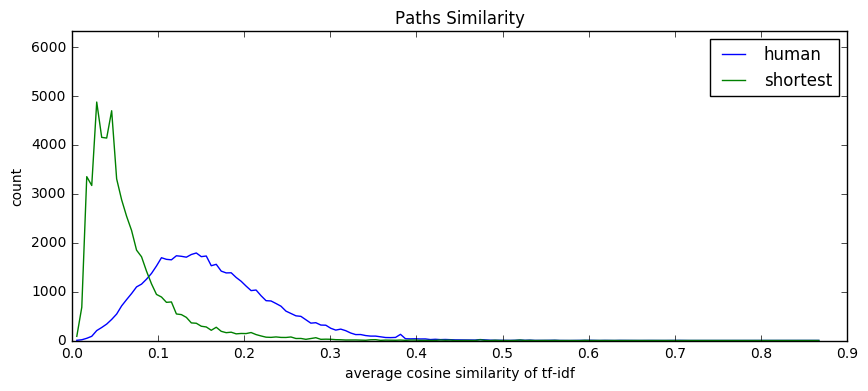

In [503]:

plt.figure(figsize=(10,4))
y,binEdges=np.histogram(human_paths_mean,bins = 150)
plt.plot(binEdges[:-1],y, color="blue")

y,binEdges=np.histogram(shortest_paths_mean,bins = 150)
plt.plot(binEdges[:-1],y, color="green")

plt.ylim(0, max(y)*1.3)
plt.title("Paths Similarity")
plt.xlabel("average cosine similarity of tf-idf")
plt.ylabel("count")
plt.legend(["human","shortest"])

plt.show()

The figure here above clearly supports the hypothesis. The human-navigation paths have more similar content than the shortest paths.

**Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.**

In [504]:
# Finally let's calculate the fraction of the time, the average similarity is lower in the case of human navigation.

human_higher = 0

for index,_ in enumerate(human_paths_mean):
    if human_paths_mean[index] > shortest_paths_mean[index]:
        human_higher += 1
    
print("The human-navigation average similarity is higher in {} out of {} times, that is {}% of the paths".format(
    human_higher,
    len(human_paths_mean),
    round_sig ( human_higher / len(human_paths_mean) * 100,6)
))

The human-navigation average similarity is higher in 46061 out of 51269 times, that is 89.8418% of the paths


According to H1, Human navigation paths have more similar content than network shortest paths. Based on our calculations of cosine similarities, the average similarity of our paths is higher in human paths than shortest paths around 89.84% of the time. This ratio is quite high therefore based on these findings, H1 is definitely true.

# Part III

## Sentiment Analysis

** Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated. ** 

- The dataset was constructed with human evaluations of the top 5000 words (sorted by frequency of each word in the text) from the text sources: Twitter, Google Books, music lyrics and New York times. The overall list is 10222 words. For evaluation of happiness of each word they asked users on Mechanical Turk to rate how a given word made them feel on a nine point integer scale, obtaining 50 independent evaluations per word. 


** Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc). The function should complain if there are no words with sentiment attached. **

The level of happiness in a text is calculated with the following equation:
$$ \sum_{i=1}^{N} h_{avg}(w_i)* p_i $$ where $p_i = f_i  /  \sum_{i=1}^{N} f_j$ and $h_{avg}(w_i)$ is the estimate of average happiness of that word. For more information about these calculations click on this [link](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#s2)

We start of by getting the average happiness of each word in Data set S1 into a dictionary. We do this by reading the dataset line by line and for each line (exept the first 4 lines) we add the word happiness average into a dictionary where the key of the dictionary is the word itself

In [505]:
from collections import defaultdict

# counter to count the number of lines that have been processed
counter = 0

happyness_rank = defaultdict(float)
path = 'Data_Set_S1.txt'
with open(path) as f:
    for line in f:
        counter += 1
        
        # we want to skip the first 4 lines of the file
        if counter > 4:
            line = line.split()
            word = line[0]  # get the word from the line
            happiness_average = float(line[2]) # get the word happiness average
            happyness_rank[word] = happiness_average

Now we are ready to create a function that calculates the sentiment of a given list of tokens.

**NOTE** We decided to return None for windows that contain no words in the dataset 1. This results in a better and more understandable plots.

In [525]:
import numpy as np

from __future__ import division

# Takes in a list of tokens and the happiness_keys which is the list of words in data set 1
# returns the mean value of the happiness rank that was found in the tokens array
# if no value was found then the function returns None
def estimateHappiness(tokens,happiness_keys):
    
    happiness_avg = [] # an array that contains the average happyness values of the tokens
    
    for token in tokens:
        # only include the words that can be found in the data set
        if token in happiness_keys: 
            happiness_avg.append(happyness_rank[token])
            
    # If no word in the tokens array is found in the dataset then we return 0
    if len(happiness_avg) == 0:
        return None
    else : 
        return np.mean(happiness_avg)

** Calculate a sentiment profile for the novels in NLPP1e chapter 1. The sentiment profile has sentiment on the y-axis and position in the text on the x-axis. Use a moving average to show how the sentiment changes. Create profiles for sliding windows of length 15 words, 50 words, 100 words, 500 words. **

Here we create a function that calculates a sentiment profile for a givent text. The function returns a dictionary for each axis X and Y which contain result for each value of the sliding window.

In [526]:
def getSentimentProfileData(text): 
    x = defaultdict(list) # container for the sentiment results for each sliding window length
    y = defaultdict(list) # container for the y axis for each sliding window length
    happiness_keys = set(happyness_rank.keys()) # The words in the data set 1
    steps = [15,50,100,500]

    for step in steps: 
        xkey = "x{}".format(step)
        ykey = "y{}".format(step)

        for i in range(len(text)-step):
            x[xkey].append(i)
            y[ykey].append(estimateHappiness(text[i:i + step], happiness_keys))
            
    return x, y

Now, everything is ready to calculate the sentiment profile for the novels in NLPP1e chapter 1. The novels are three and can be found in the nltk module under books.

The novels are the following texts:

    - text1: Moby Dick by Herman Melville 1851
    - text2: Sense and Sensibility by Jane Austen 1811
    - text9: The Man Who Was Thursday by G . K . Chesterton 1908

In [509]:
# Get the novels from the nltk module

import nltk
from nltk.book import *

novels = [text1,text2,text9]

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


Finally everything is ready to run our functions. This will result in profiles for each text for sliding windows of length 15 words, 50 words, 100 words, 500 words. We create four plots for each novel, each plot has a different value of for the sliding window.

Moby Dick


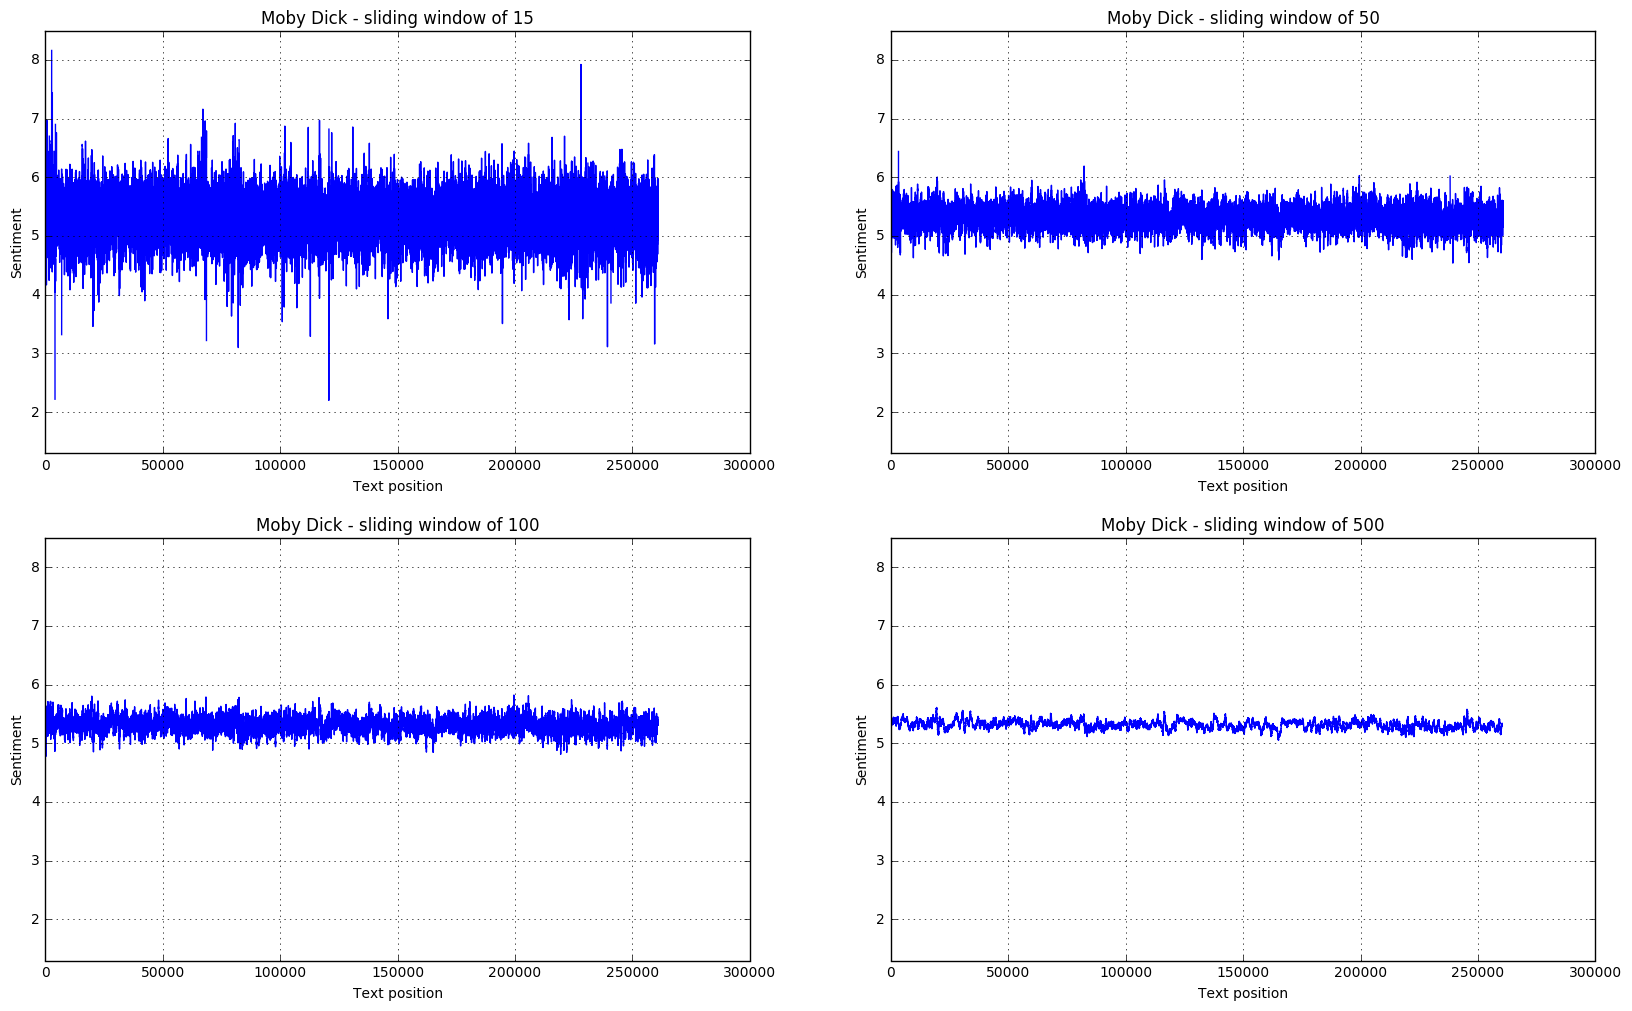

Sense and Sensibility


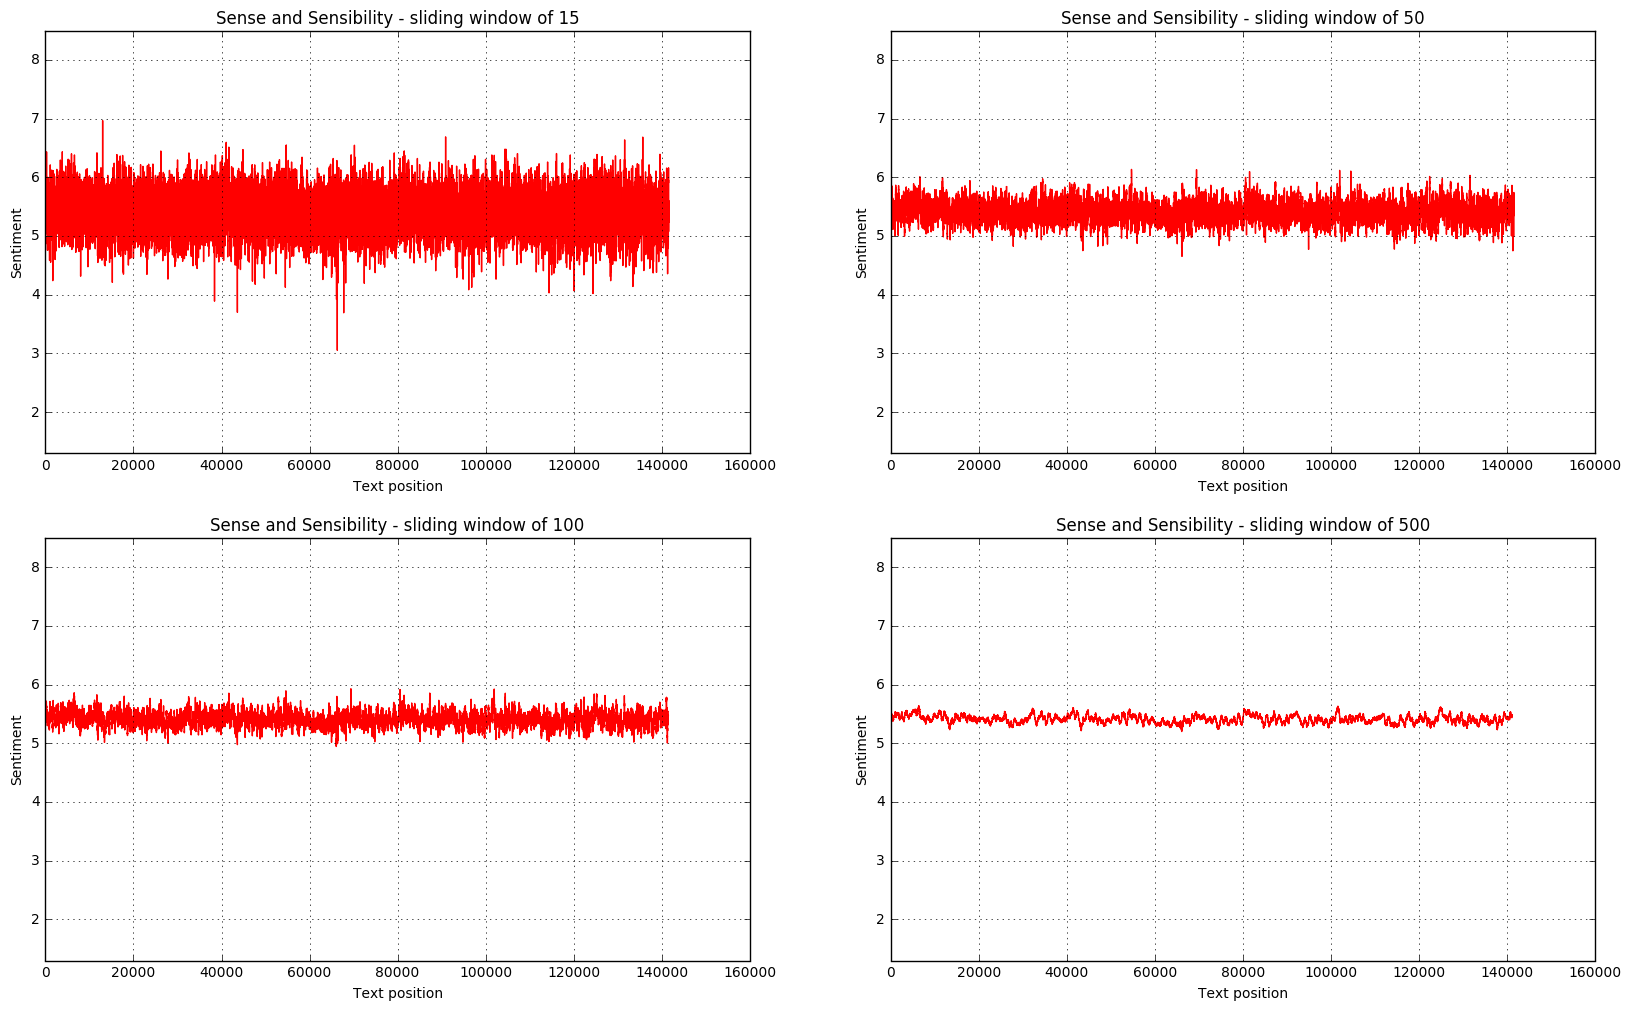

The Man Who Was Thursday


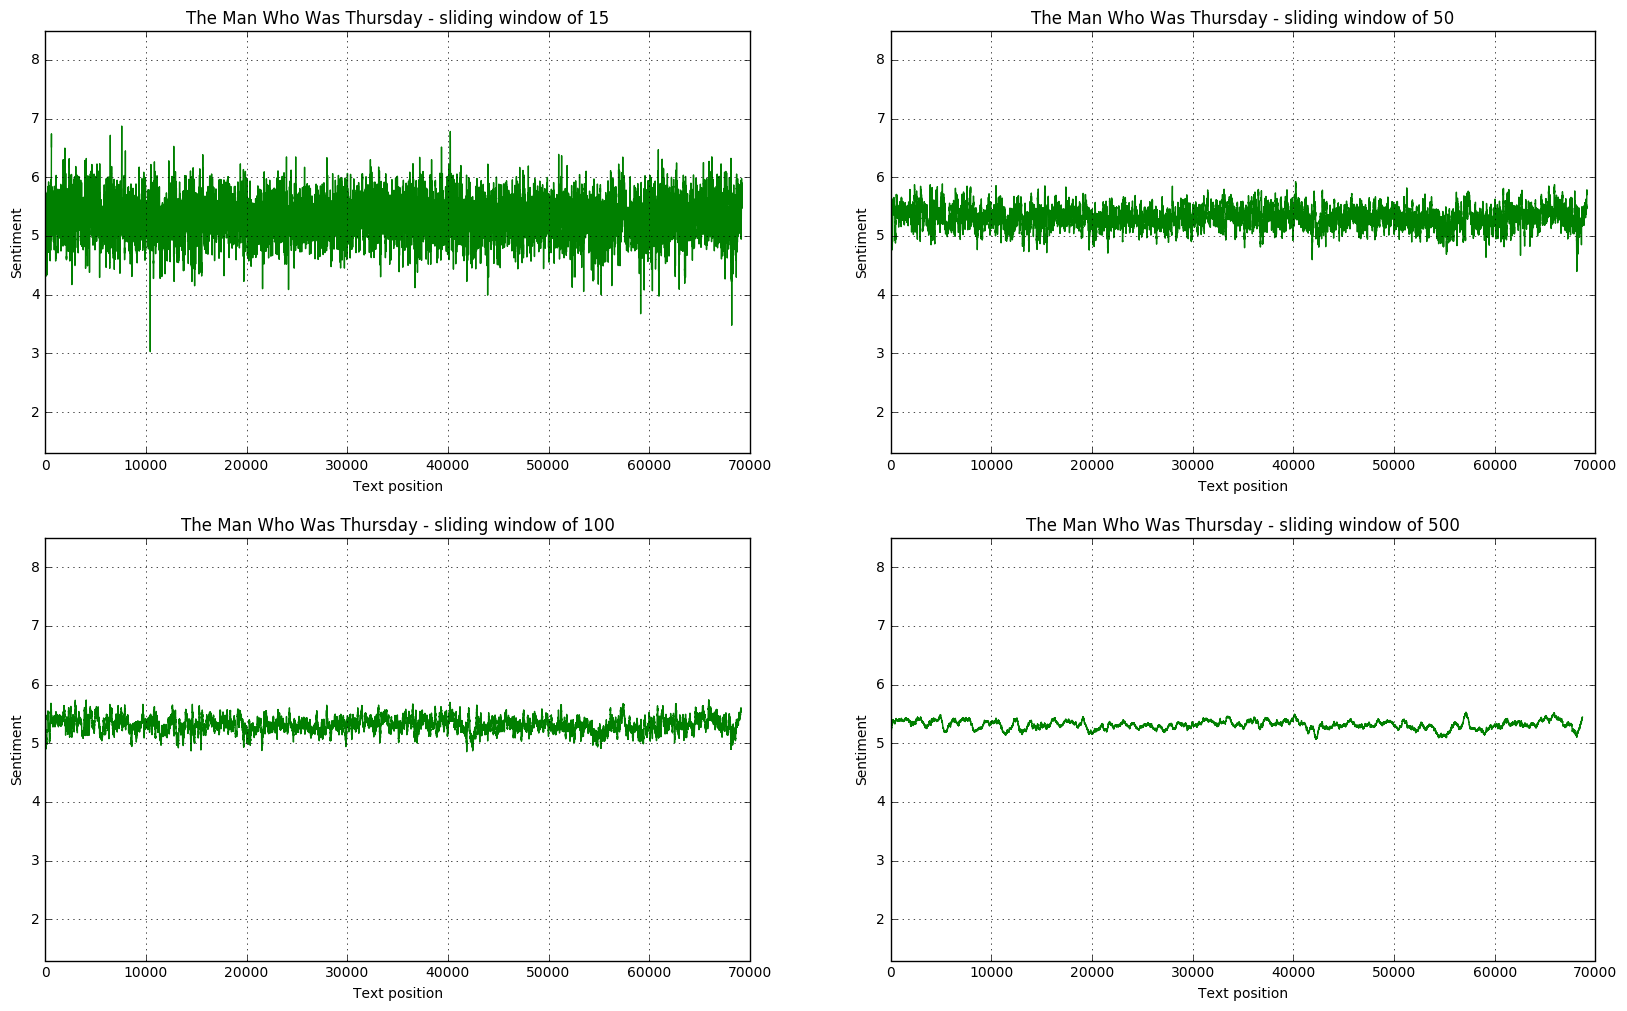

In [620]:
import matplotlib.pyplot as plt
colors = ["blue","red","green"]
titles = ["Moby Dick", "Sense and Sensibility", "The Man Who Was Thursday"]

# Array that contains the values for the sliding window of 500

window_500 = {
    "Moby Dick" : [],
    "Sense and Sensibility": [],
    "The Man Who Was Thursday": []
}


for i,novel in enumerate(novels):
    
    print titles[i]
    
    # Calculate the sentiment profile for the novel
    x, y = getSentimentProfileData(novel)

    # plot the result
    plt.figure(figsize=(20,12))

    # sliding window of length 15
    plt.subplot(221)
    plt.plot(x["x15"], y["y15"], color=colors[i])
    plt.ylim(ymin=1.3, ymax=8.5)
    plt.xlabel("Text position")
    plt.ylabel("Sentiment")
    plt.title('{} - sliding window of 15'.format(titles[i]))
    plt.grid(True)

    # sliding window of length 50
    plt.subplot(222)
    plt.plot(x["x50"], y["y50"], color=colors[i])
    plt.ylim(ymin=1.3, ymax=8.5)
    plt.xlabel("Text position")
    plt.ylabel("Sentiment")
    plt.title('{} - sliding window of 50'.format(titles[i]))
    plt.grid(True)

    # sliding window of length 100
    plt.subplot(223)
    plt.plot(x["x100"], y["y100"], color=colors[i])
    plt.ylim(ymin=1.3, ymax=8.5)  
    plt.xlabel("Text position")
    plt.ylabel("Sentiment")
    plt.title('{} - sliding window of 100'.format(titles[i]))
    plt.grid(True)

    # sliding window of length 500
    plt.subplot(224)
    plt.plot(x["x500"], y["y500"], color=colors[i])
    plt.ylim(ymin=1.3, ymax=8.5)
    plt.xlabel("Text position")
    plt.ylabel("Sentiment")
    plt.title('{} - sliding window of 500'.format(titles[i]))
    plt.grid(True)
    
    window_500[titles[i]].append((x["x500"],y["y500"]))
    
    plt.show()

Finally we plot one graph where all of the novels are plotted together on the same graph with the sliding window of 500 to see the difference in happiness of the books

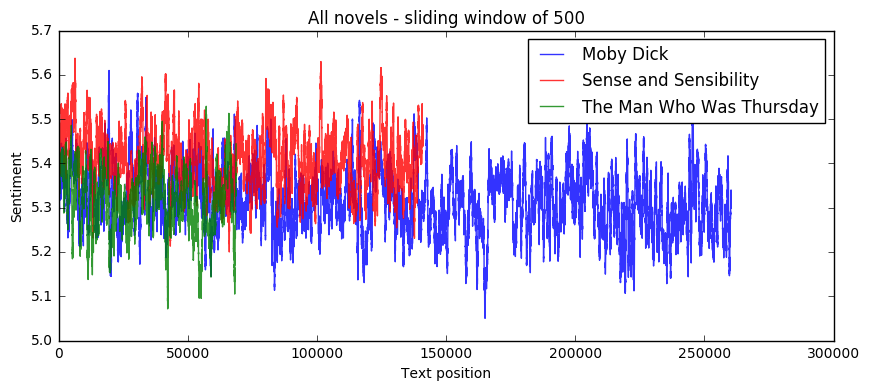

In [622]:
plt.figure(figsize=(10,4))
for i,novel in enumerate(titles):
    plt.plot(window_500[novel][0][0],window_500[novel][0][1], color = colors[i], alpha=0.8)
    
plt.xlabel("Text position")
plt.ylabel("Sentiment")
plt.title("All novels - sliding window of 500")
plt.legend(titles)

plt.show()


** Comment on the sentiment profiles. Do they show a similar pattern? What is the effect of changing the size of the sliding window? **

Looking at all the plots, we would recommend any reader to read "Sense and Sensibility" if he wants to be happy. However, if you are feeling down and don’t really feel like being happy "Moby Dick" or "The Man Who Was Thursday"  is the right choice for you. 

Overall "Moby Dick" seems to be the saddest book of them all and "Sense and Sensibility" is noticeable happier than the other two books (at least contains happier words).

*If you are interested in more and deeper analyses of the books, we advise the reader to continue, otherwise just dont.*

**Note**: 
- The **max** value appears if we do an average where only the happiest word would be used in the window, the score of that sentence would be: 8.5.
- Likewise the **min** value appears if only the most unhappy word was used in the window, the score of there would be: 1.30. 
- This will give you more intuitive feeling regarding the happiness values. Furthermore, we also used these values as the min and max values on y axis when plotting up the sliding windows. We used the same scale on all plots to be able to compare the difference between the sliding windows.


**What is the effect of changing the size of the sliding window? **

We can see that with a different sliding window we will get a different outcomes. Having a small sliding window makes the algorithm essentially just evaluate few words or maybe a sentence in each step. This tells us how sentences through out the book relate to happiness. However, when increased, the algorithm takes bigger chunks of text into account, making the moving average tell us more about the chapters and the "flow" of the book. By increasing the window size we reduce the fluctation in the graph, which is understandable when you are average over more word, but we still have some fluctuation. This can be seen by looking at the graphs where the window size is 500. There is still a minor fluctuation in the stories which correspont to sad or happy moments in the book.


**Do they show a similar pattern?**

Comparing the books we would advise the reader to look more on the bigger sliding windows (with value 100 and 500) when looking for similar books. There we can see the flow of the books and see if the books fluctuate between happy and sad in a similar way. When looking at our figures it is hard to tell which books fluctuate in a similar way. However, we can see that Moby Dick and The Man Who Was Thursday is unhappier than Sense And Sensibility, at least uses unhappier language.

Notice that all the books fluctuad a lot, however they all seem to use rather happy language. The reason is simple, we see that all the books fluctuate around 4.9 (the value in middle of the best and worst value), but they all seem to be above that line on average. To further support that claim, we like to point at the fact that most sentances include a lot of stop words, most of them are rather neutral in the dataset (fx "the" has a score of 4.98), and thus pulling the score towards the mean. Here it would be a good idea to clean all the stopwords from the stories. That way the words would tell us much more, if the story is happy or not. However, on the downside, it would be harder to find out where the happy and unhappy parts of the book are located, as we have cleaned a lot of words from the text. 

** Interesting things to notice**

- One interesting thing seems to happen in the beginning of "Moby Dick". If you look at the figure having 15 as the size of the sliding window, we can see that the beginning appears to be really happy, then something dramatic happens and the book starts to rather unhappy and sad. The fluctiation in the "Moby Dick" novel also seems to be more than in the other two novel. This is understandable when you consider the nature of these books. "Moby Dick" is an epic adventure novel that has a lot of ups and downs.

- One interesting point in the Moby Dick novel can be seen around 170.000 words in where something really sad seems to happen.

- We can see in three of the plots for The Man Who Was Thursday that the end is a sort of a cliffhanger as it gets quite unhappy before taking a turn and ending  on a happier note. This fits well as the book ends with the main character waking up and realising that this has been a nightmare.
